# Break AES using DPA with correlations

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously


In [49]:
import matplotlib.pyplot as plt
import numpy as np

In [50]:
# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')

# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

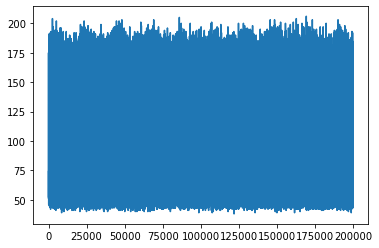

In [51]:
# read plaintext inputs
inputs = load_text("plaintext.txt")

# read length of one complete trace (number of samples per trace)
with open("traceLength.txt", "r") as fin:
  trace_length = int(fin.readline())



# read traces from binary file
traces = np.fromfile("traces.bin", dtype='uint8') # read as linear array
traces = np.reshape(traces, (traces.size // trace_length, trace_length)) # reshape into matrix

# 1. Zobrazte jeden nebo několik málo kompletních průběhů
fig = plt.figure()
plt.plot(traces[0])
plt.show()

# 2. Vyberte část průběhů, která je zajímavá pro DPA, viz přednášku o útocích postranními kanály
# 1 průběh = 1 blok dat = 10 rund 
# 3. Změňte program tak, aby nahrával pouze zajímavé části všech průběhů
# odhadneme, že první runda nastává v prvních 25000 vzorcích 
# trim each trace - select interesting part
start = 0
len = 25000 # CHANGE to the length of the first round;


traces = traces[:, start:len] # select only the interesting part of each trace

In [52]:
print(inputs.shape) # dimensions of inputs
print(trace_length)
print(traces.shape) # dimensions of matrix of traces

(100, 16)
200000
(100, 25000)


In [53]:
# If you feel brave enough -- interactive plots
#!pip install ipympl
#from google.colab import output
#output.enable_custom_widget_manager()
#%matplotlib widget

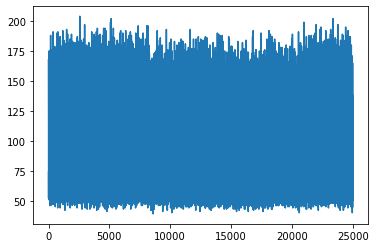

In [54]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[0])
plt.show()


## **Attack the first key byte**
![Intermediate value](dpa-aes-v.png)


In [55]:
# Generate key hypotheses (all possible byte values)
keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
# Select the first byte of each input block
inp = inputs[:, 0]
# XOR each data byte with each key
xmat = inp[:, np.newaxis] ^ keys

In [56]:
# Examine the inputs matrix. Does it contain the data from plaintext.txt?
print(inputs)
# What is the shape of all the operands from the previous cell?
print(inputs.shape)
print(inp.shape)
print(inp[:, np.newaxis].shape)
print(keys.shape)
print(xmat.shape)
# Do you understand the values after the XOR operation? What AES operation do they represent?
print(xmat)

[[ 37 235 140 ...  71 237 252]
 [134  25 178 ... 142  50  68]
 [215 215 233 ...  61  22  57]
 ...
 [ 18 188 253 ...  68 197 189]
 [ 87 194  19 ... 160   8 136]
 [148 238  68 ...  23  94 218]]
(100, 16)
(100,)
(100, 1)
(256,)
(100, 256)
[[ 37  36  39 ... 216 219 218]
 [134 135 132 ... 123 120 121]
 [215 214 213 ...  42  41  40]
 ...
 [ 18  19  16 ... 239 236 237]
 [ 87  86  85 ... 170 169 168]
 [148 149 150 ... 105 106 107]]


In [57]:
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]
print(smat)

[[ 63  54 204 ...  97 185  87]
 [ 68  23  95 ...  33 188 182]
 [ 14 246   3 ... 229 165  52]
 ...
 [201 125 202 ... 223 206  85]
 [ 91 177 252 ... 172 211 194]
 [ 34  42 144 ... 249   2 127]]


In [58]:
# Compute Hamming Weights -- the matrix of hypothetical power consumption
hmat = hw_table[smat]

(100, 256)
(100, 25000)
(256, 25000)


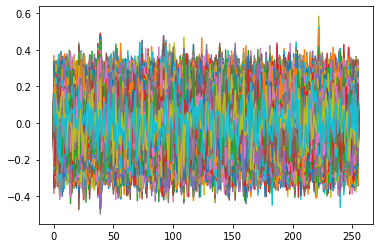

In [64]:
# Compute the correlation matrix -- correlate the hypotheses with measured traces
print(hmat.shape)
print(traces.shape)
corr = correlate(hmat, traces)
# What is the shape and contents of the correlation matrix?
print(corr.shape)
fig = plt.figure()
plt.plot(corr)
plt.show()


In [70]:
# Find the absolute maximum correlation
acorr = abs(corr)
max_acorr = acorr.max()
(k, j) = np.where(acorr == max_acorr) # find idices of maximum
# 4. Doplňte program tak, aby prolomil první bajt klíče

print("key: %d time: %d" % (k[0], j[0]))
print("key: %1c, %02x" % (k[0], k[0]))

key: 222 time: 3348
key: Þ, de


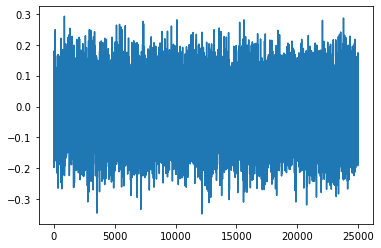

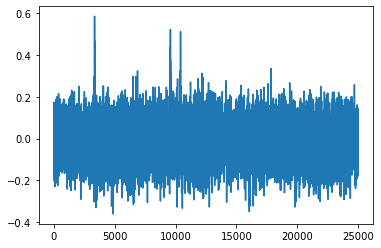

In [71]:
# Plot the correlation traces for the right key byte guess and one wrong key byte guess
# Do you see the correlation peaks?
fig = plt.figure()
# 6. Zobrazte průbeh korelace pro špatnou hypotézu, porovnejte
plt.plot(corr[200,:])
plt.show()
# 5. Zobrazte průběh korelace pro správnou hypotézu klíče, pozorujte špičky korelačního koeficientu
plt.plot(corr[222,:])
plt.show()

## **Break all key bytes!**

In [76]:
# 7. Doplňte kód tak, abyste prolomili celý klíč
keys = np.array(range(0, 256))
kk = np.zeros(16, dtype='uint8')
for i in range(0, 16):
    inp = inputs[:, i]
    xmat = inp[:, np.newaxis] ^ keys
    smat = sbox[xmat]
    hmat = hw_table[smat]
    corr = correlate(hmat, traces)
    acorr = abs(corr)
    max_acorr = acorr.max()
    (k, j) = np.where(acorr == max_acorr)
    kk[i] = k
    print("%1c, %02x @ %d" % (k[0], k[0], j[0]))
    
print("key: %02x%02x%02x%02x%02x%02x%02x%02x%02x%02x%02x%02x%02x%02x%02x%02x" % (kk[0], kk[1], kk[2], kk[3], kk[4], kk[5], kk[6], kk[7], kk[8], kk[9], kk[10], kk[11], kk[12], kk[13], kk[14], kk[15]))

Þ, de @ 3348
­, ad @ 15779
¾, be @ 3829
ï, ef @ 4045
 , 20 @ 4280
t, 74 @ 9180
o, 6f @ 4744
p, 70 @ 9064
 , 20 @ 5209
s, 73 @ 5441
e, 65 @ 5678
c, 63 @ 17859
r, 72 @ 17175
e, 65 @ 13170
t, 74 @ 6605
!, 21 @ 6837
key: deadbeef20746f702073656372657421


## **Verify the key on a PT, CT pair!**

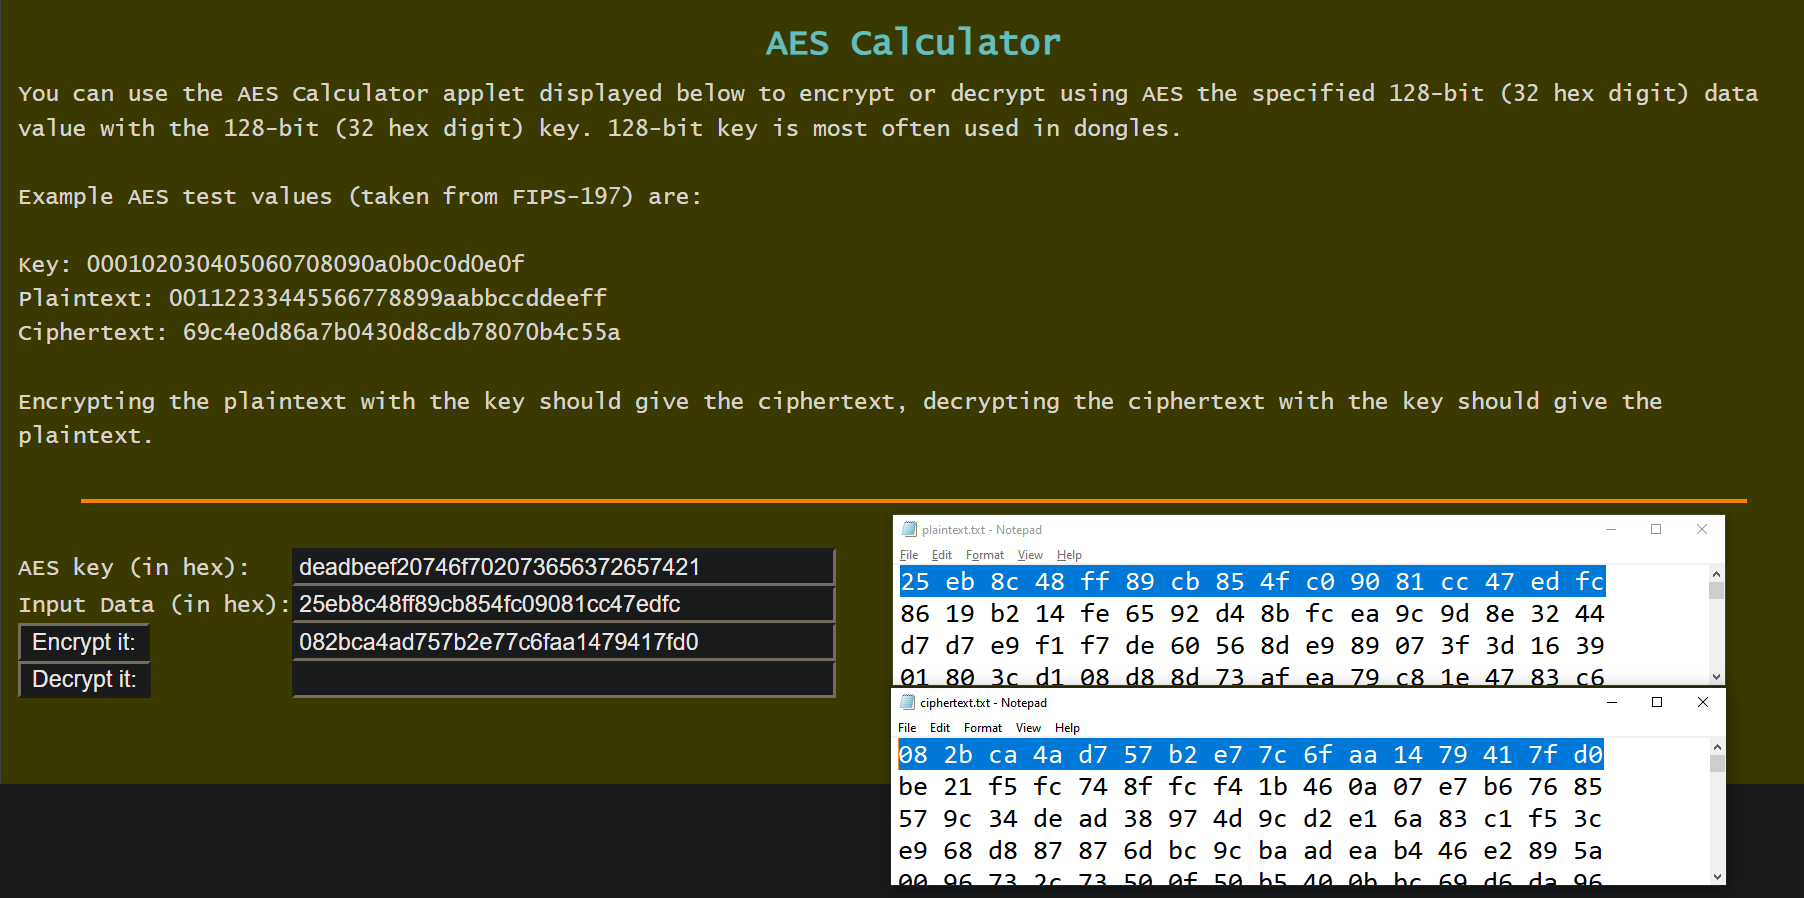

In [3]:
from IPython import display
display.Image("./overeni-klice.PNG")